# **Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **GPU**

In [2]:
!nvidia-smi

Sun Nov  3 06:57:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# **Install**

In [3]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 16.6 MB/s eta 0:00:00


# **Imports**

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.backends.cudnn as cudnn

import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# **Init**

In [5]:
num_cls = 10

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# **Utils**

In [6]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
def num_params(model):
  nums = sum(p.numel() for p in model.parameters())/1e6
  return nums

# **Dataset**

## Transform

In [9]:
transform_train = T.Compose([T.RandomCrop(32, padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                         std=(0.2023, 0.1994, 0.2010))])

transform_test = T.Compose([T.ToTensor(),
                            T.Normalize(mean=(0.4914, 0.4822, 0.4465),
                                        std=(0.2023, 0.1994, 0.2010))])

## CIFAR Dataset

In [10]:
train_set = CIFAR10(root='./deep-learning-2022-howsam/cifar10', train=True,
                    download=True,
                    transform=transform_train)

test_set = CIFAR10(root='./deep-learning-2022-howsam/cifar10', train=False,
                   download=True,
                   transform=transform_test)

100%|██████████| 170M/170M [00:04<00:00, 42.5MB/s]


Extracting ./deep-learning-2022-howsam/cifar10/cifar-10-python.tar.gz to ./deep-learning-2022-howsam/cifar10
Files already downloaded and verified


In [11]:
train_set.data.shape

(50000, 32, 32, 3)

## DataLoader

In [12]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

In [13]:
x, y = next(iter(train_loader))
print(x.shape)
print(y)

torch.Size([64, 3, 32, 32])
tensor([4, 5, 8, 7, 7, 8, 4, 5, 9, 4, 0, 6, 8, 2, 5, 5, 6, 4, 9, 4, 5, 7, 8, 1,
        2, 0, 0, 2, 4, 8, 7, 3, 0, 7, 7, 1, 5, 9, 4, 4, 7, 4, 7, 2, 4, 6, 5, 5,
        2, 3, 3, 8, 3, 9, 8, 7, 5, 4, 3, 5, 9, 2, 4, 6])


## Visualize

In [14]:
def normalize_image(image):
  image_min = image.min()
  image_max = image.max()
  image.clamp_(min = image_min, max = image_max)
  image.add_(-image_min).div_(image_max - image_min + 1e-5)
  return image

def plot_images(images, labels, classes, normalize=True):
  n_images = len(images)

  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize=(10, 10))

  for i in range(rows*cols):

    ax = fig.add_subplot(rows, cols, i+1)

    image = images[i]
    if normalize:
      image = normalize_image(image)

    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    ax.set_title(classes[labels[i]])
    ax.axis('off')

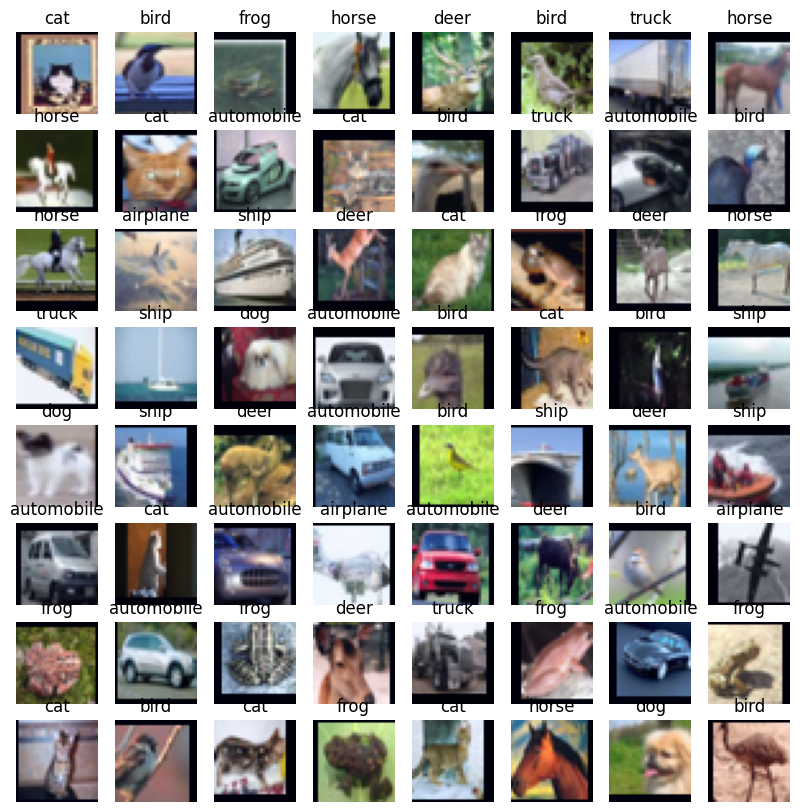

In [15]:
batch = next(iter(train_loader))
classes = train_set.classes
plot_images(batch[0], batch[1], classes)

# **Model 🧠**

In [16]:
def conv3x3_bn_af(in_channels, out_channels):
  module = nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, padding=1),
                         nn.BatchNorm2d(out_channels),
                         nn.ReLU())
  return module

Teacher model:
This is a deep CNN with four stages, each consisting of two convolutional layers followed by a max-pooling layer. It ends with an adaptive average pooling layer and a fully connected layer.

Student model:
This model is shallower, with only one convolutional layer per stage. It also uses max-pooling and ends with a linear classifier.

In [17]:
def Teacher():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          conv3x3_bn_af(64, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          conv3x3_bn_af(128, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          conv3x3_bn_af(256, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          conv3x3_bn_af(512, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [18]:
def Student():
  network = nn.Sequential(conv3x3_bn_af(3, 64),
                          nn.MaxPool2d(2, 2), # 16x16

                          conv3x3_bn_af(64, 128),
                          nn.MaxPool2d(2, 2), # 8x8

                          conv3x3_bn_af(128, 256),
                          nn.MaxPool2d(2, 2), # 4x4

                          conv3x3_bn_af(256, 512),
                          nn.AdaptiveAvgPool2d(output_size=(1, 1)), # 1x1

                          nn.Flatten(),
                          nn.Linear(512, 10) # classifier
                      )

  return network

In [19]:
teacher = Teacher().to(device)
num_params(teacher)

4.694346

In [20]:
student = Student().to(device)
num_params(student)

1.558026

# **Functions**

In [21]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_cls).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [22]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=num_cls).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

In [23]:
def train_one_epoch_kd(student, teacher, train_loader, loss_fn, optimizer, epoch=None):
  student.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=num_cls).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = student(inputs)
      with torch.no_grad():
        teacher_outputs = teacher(inputs)

      loss = loss_fn(outputs, targets, teacher_outputs, T=10, alpha=0.6)

      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return student, loss_train.avg, acc_train.compute().item()

# **Train Teacher & Student Models**

## Step 1: check forward path

Calculate loss for one batch

In [24]:
teacher = Teacher().to(device)
loss_fn = nn.CrossEntropyLoss()

x_batch, y_batch = next(iter(train_loader))
outputs = teacher(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))
print(loss)

tensor(2.3200, device='cuda:0', grad_fn=<NllLossBackward0>)


## Step 2: check backward path

Select 5 random batches and train the model

In [25]:
_, mini_train_dataset = random_split(train_set, (len(train_set)-500, 500))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [47]:
teacher = Teacher().to(device)
loss_fn = nn.CrossEntropyLoss()

In [27]:
optimizer = optim.SGD(teacher.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 100
for epoch in range(num_epochs):
  teacher, _, _ = train_one_epoch(teacher, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 99: 100%|██████████| 25/25 [00:00<00:00, 30.51batch/s, accuracy=100, loss=0.000908]


## Step 3: select best lr

Train all data for one epoch

In [ ]:
num_epochs = 3
for lr in [0.9, 0.5, 0.2, 0.1, 0.01, 0.001, 0.0001]:
  print(f'LR={lr}')
  teacher = Teacher().to(device)
  optimizer = optim.SGD(teacher.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
  for epoch in range(num_epochs):
    teacher, _, _ = train_one_epoch(teacher, train_loader, loss_fn, optimizer, epoch)
  print()

LR=0.9


Epoch 2: 100%|██████████| 782/782 [00:44<00:00, 17.65batch/s, accuracy=42.9, loss=1.54]



LR=0.5


Epoch 2: 100%|██████████| 782/782 [00:44<00:00, 17.41batch/s, accuracy=60.5, loss=1.11]



LR=0.2


Epoch 2: 100%|██████████| 782/782 [00:48<00:00, 16.06batch/s, accuracy=69, loss=0.885]



LR=0.1


Epoch 2: 100%|██████████| 782/782 [00:45<00:00, 17.09batch/s, accuracy=73.2, loss=0.765]



LR=0.01


Epoch 2: 100%|██████████| 782/782 [00:46<00:00, 16.90batch/s, accuracy=77.4, loss=0.644]



LR=0.001


Epoch 2: 100%|██████████| 782/782 [00:45<00:00, 17.10batch/s, accuracy=72.2, loss=0.797]



LR=0.0001


Epoch 2: 100%|██████████| 782/782 [00:47<00:00, 16.50batch/s, accuracy=50.4, loss=1.39]

## Step 4: small grid (optional)

Create a small grid based on the WD and the best LR



In [ ]:
num_epochs = 5

for lr in [0.05, 0.04, 0.03, 0.02, 0.01, 0.009, 0.008, 0.007, 0.006, 0.005]:
  for wd in [1e-4, 1e-5, 0.]:
    teacher = Teacher().to(device)
    optimizer = optim.SGD(teacher.parameters(), lr=lr, weight_decay=wd)
    print(f'LR={lr}, WD={wd}')

    for epoch in range(num_epochs):
      teacher, loss, _ = train_one_epoch(teacher, train_loader, loss_fn, optimizer, epoch)
    print()

## Step 5: train more epochs

In [33]:
teacher = Teacher().to(device)

In [34]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(teacher.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [35]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [36]:
num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(teacher,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(teacher,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(teacher, f'teacher.pt')
    best_loss_valid = loss_valid
    print('Teacher Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:45<00:00, 17.07batch/s, accuracy=55.2, loss=1.24]


Teacher Model Saved!
Valid: Loss = 0.9488, Acc = 0.6721



Epoch 1: 100%|██████████| 782/782 [00:45<00:00, 17.01batch/s, accuracy=72.5, loss=0.787]


Teacher Model Saved!
Valid: Loss = 0.8746, Acc = 0.7086



Epoch 2: 100%|██████████| 782/782 [00:44<00:00, 17.48batch/s, accuracy=77.9, loss=0.637]


Teacher Model Saved!
Valid: Loss = 0.6764, Acc = 0.7735



Epoch 3: 100%|██████████| 782/782 [00:45<00:00, 17.13batch/s, accuracy=80.8, loss=0.552]


Valid: Loss = 0.7075, Acc = 0.7668



Epoch 4: 100%|██████████| 782/782 [00:45<00:00, 17.24batch/s, accuracy=83, loss=0.492]


Teacher Model Saved!
Valid: Loss = 0.5313, Acc = 0.8241



Epoch 5: 100%|██████████| 782/782 [00:46<00:00, 16.88batch/s, accuracy=84.6, loss=0.445]


Valid: Loss = 0.544, Acc = 0.8184



Epoch 6: 100%|██████████| 782/782 [00:45<00:00, 17.16batch/s, accuracy=85.9, loss=0.408]


Teacher Model Saved!
Valid: Loss = 0.5147, Acc = 0.828



Epoch 7: 100%|██████████| 782/782 [00:45<00:00, 17.19batch/s, accuracy=87, loss=0.371]


Valid: Loss = 0.6954, Acc = 0.7794



Epoch 8: 100%|██████████| 782/782 [00:45<00:00, 17.29batch/s, accuracy=88.1, loss=0.347]


Teacher Model Saved!
Valid: Loss = 0.492, Acc = 0.8408



Epoch 9: 100%|██████████| 782/782 [00:47<00:00, 16.39batch/s, accuracy=88.5, loss=0.33]


Valid: Loss = 0.5296, Acc = 0.8226



# **Train Knowledge Distillation**

Imagine you’re training a student model to recognize images of animals, and your dataset has three classes: **Cat**, **Dog**, and **Bird**. For a particular image, the true label is **Cat**.

### Without Knowledge Distillation (Standard Cross-Entropy Loss)
If you train the student model using only cross-entropy loss, you compare the student’s output directly with the true label, **Cat**. Let’s say the student outputs the following probabilities:

- **Cat**: 80%
- **Dog**: 10%
- **Bird**: 10%

The cross-entropy loss encourages the student to make **Cat** the highest probability, which is good. But it doesn’t tell the student much about **why** Dog and Bird should be lower probabilities or how similar they are to Cat, which is something the teacher might know.

### With Knowledge Distillation (Using Teacher's Soft Labels)
Now let’s say you have a trained **Teacher** model that has a more nuanced understanding of animals. For the same image, the teacher’s output might look like this with a high **temperature** (`T=5`):

- **Cat**: 60%
- **Dog**: 30%
- **Bird**: 10%

The teacher gives a high probability for **Cat** but also shows some similarity between **Cat** and **Dog** (30% for Dog), which might make sense if the image has features that are shared between cats and dogs, like fur or four legs. The soft labels tell the student that **Dog** is more similar to **Cat** than **Bird** is, giving the student richer information about the relationships between classes.

### The Loss Function in Action
The knowledge distillation loss combines:

1. **KL Divergence** (first part) to compare the **soft labels** from the teacher and the student:
   - This encourages the student to produce probabilities similar to the teacher’s output, capturing the teacher’s "knowledge" about the relationships between classes. The temperature 𝑇 "softens" the output probabilities of both the teacher and student models, making the distribution less "peaked." This is crucial because softened probabilities reveal more information about class similarities. For example:
    Without softening (e.g., 𝑇 = 1), the teacher might output Cat: 98%, Dog: 1%, and Bird: 1%. With 𝑇 = 5, the same output might look like Cat: 60%, Dog: 30%, Bird: 10%. The softened output makes it easier for the student to understand that Dog is more similar to Cat than Bird is.

2. **Cross-Entropy Loss** (second part) to compare the student’s prediction with the **true label**:
   - This ensures the student model is still focusing on the true label, **Cat**, so it doesn’t deviate too far from the main task.

The `alpha` parameter controls how much we want the student to rely on the teacher’s guidance (`KL Divergence`) versus the true label (`Cross-Entropy Loss`).

### Putting It All Together
By blending these two objectives, knowledge distillation teaches the student not only to recognize **Cat** as the correct answer but also to understand that **Dog** is somewhat similar, while **Bird** is less so. This often leads to a student model that generalizes better to new, unseen data because it’s learned a deeper understanding from the teacher.

## Knowledge distillation loss

In [37]:
def loss_fn_kd(outputs, labels, teacher_outputs, T, alpha):
  loss = F.kl_div(F.log_softmax(outputs/T, dim=1),
                  F.softmax(teacher_outputs/T, dim=1),
                  reduction='batchmean') * (alpha * T**2) + \
         F.cross_entropy(outputs, labels) * (1 - alpha)
  return loss

## Train

In [38]:
teacher = torch.load('teacher.pt')
teacher.eval()

<ipython-input-38-a955394597df>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher = torch.load('teacher.pt')


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): S

In [43]:
student = Student().to(device)

In [44]:
lr = 0.01
wd = 1e-4
optimizer = optim.SGD(student.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [45]:
loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [46]:
num_epochs = 15

for epoch in range(num_epochs):
  # Train
  student, loss_train, acc_train = train_one_epoch_kd(student,
                                                      teacher,
                                                      train_loader,
                                                      loss_fn_kd,
                                                      optimizer,
                                                      epoch)
  # Validation
  loss_valid, acc_valid = validation(student,
                                     test_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0: 100%|██████████| 782/782 [00:43<00:00, 18.01batch/s, accuracy=52.8, loss=3.29]


Valid: Loss = 1.179, Acc = 0.6514



Epoch 1: 100%|██████████| 782/782 [00:43<00:00, 17.79batch/s, accuracy=69.7, loss=1.65]


Valid: Loss = 0.9546, Acc = 0.7106



Epoch 2: 100%|██████████| 782/782 [00:49<00:00, 15.72batch/s, accuracy=74.8, loss=1.22]


Valid: Loss = 0.8409, Acc = 0.7457



Epoch 3: 100%|██████████| 782/782 [00:43<00:00, 17.84batch/s, accuracy=77.4, loss=1.02]


Valid: Loss = 0.8406, Acc = 0.7554



Epoch 4: 100%|██████████| 782/782 [00:43<00:00, 18.16batch/s, accuracy=79.4, loss=0.89]


Valid: Loss = 0.6563, Acc = 0.7964



Epoch 5: 100%|██████████| 782/782 [00:43<00:00, 17.99batch/s, accuracy=80.7, loss=0.805]


Valid: Loss = 0.5768, Acc = 0.8165



Epoch 6: 100%|██████████| 782/782 [00:42<00:00, 18.28batch/s, accuracy=81.9, loss=0.745]


Valid: Loss = 0.6539, Acc = 0.7999



Epoch 7: 100%|██████████| 782/782 [00:42<00:00, 18.32batch/s, accuracy=82.4, loss=0.704]


Valid: Loss = 0.6483, Acc = 0.7974



Epoch 8: 100%|██████████| 782/782 [00:43<00:00, 18.10batch/s, accuracy=83.4, loss=0.655]


Valid: Loss = 0.5446, Acc = 0.8248



Epoch 9: 100%|██████████| 782/782 [00:43<00:00, 18.14batch/s, accuracy=83.8, loss=0.629]


Valid: Loss = 0.5149, Acc = 0.8304



Epoch 10: 100%|██████████| 782/782 [00:42<00:00, 18.22batch/s, accuracy=84.1, loss=0.607]


Valid: Loss = 0.5081, Acc = 0.8355



Epoch 11: 100%|██████████| 782/782 [00:43<00:00, 17.82batch/s, accuracy=84.6, loss=0.594]


Valid: Loss = 0.6266, Acc = 0.8112



Epoch 12: 100%|██████████| 782/782 [00:43<00:00, 18.10batch/s, accuracy=84.9, loss=0.583]


Valid: Loss = 0.56, Acc = 0.8201



Epoch 13: 100%|██████████| 782/782 [00:43<00:00, 18.14batch/s, accuracy=85.1, loss=0.561]


Valid: Loss = 0.5042, Acc = 0.8373



Epoch 14: 100%|██████████| 782/782 [00:43<00:00, 18.06batch/s, accuracy=85.5, loss=0.549]


Valid: Loss = 0.4679, Acc = 0.8444



# **Plot**

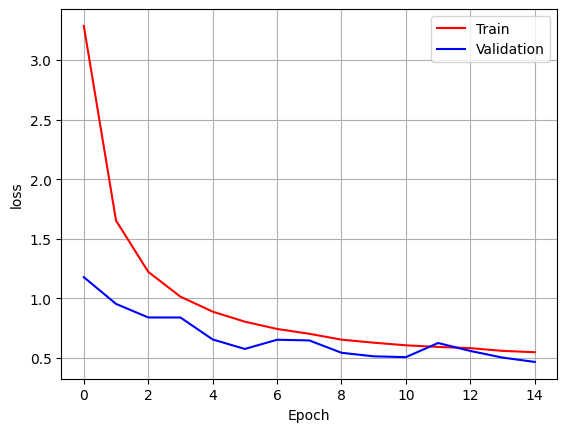

In [48]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

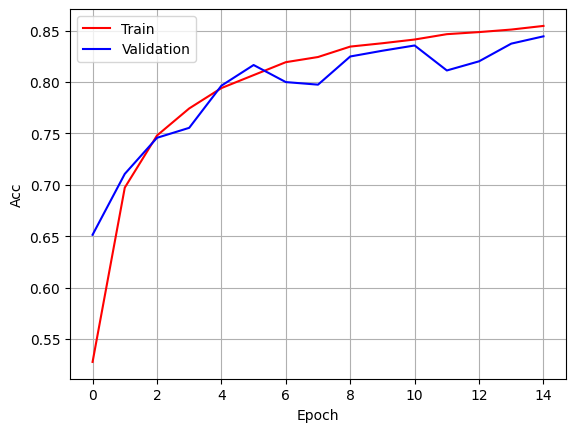

In [49]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()